In [ ]:
!pip install pyspark

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
.master("local")\
.appName("ClusteringApp")\
.enableHiveSupport()\
.config('spark.ui.port', '4050')\
.getOrCreate()


In [ ]:
path="/content/Customer.csv"

In [4]:
#Reading  onlineRetailfile
path="/content/Customer.csv"
df = spark.read.csv(path,
                             inferSchema=True,
                             header=True)

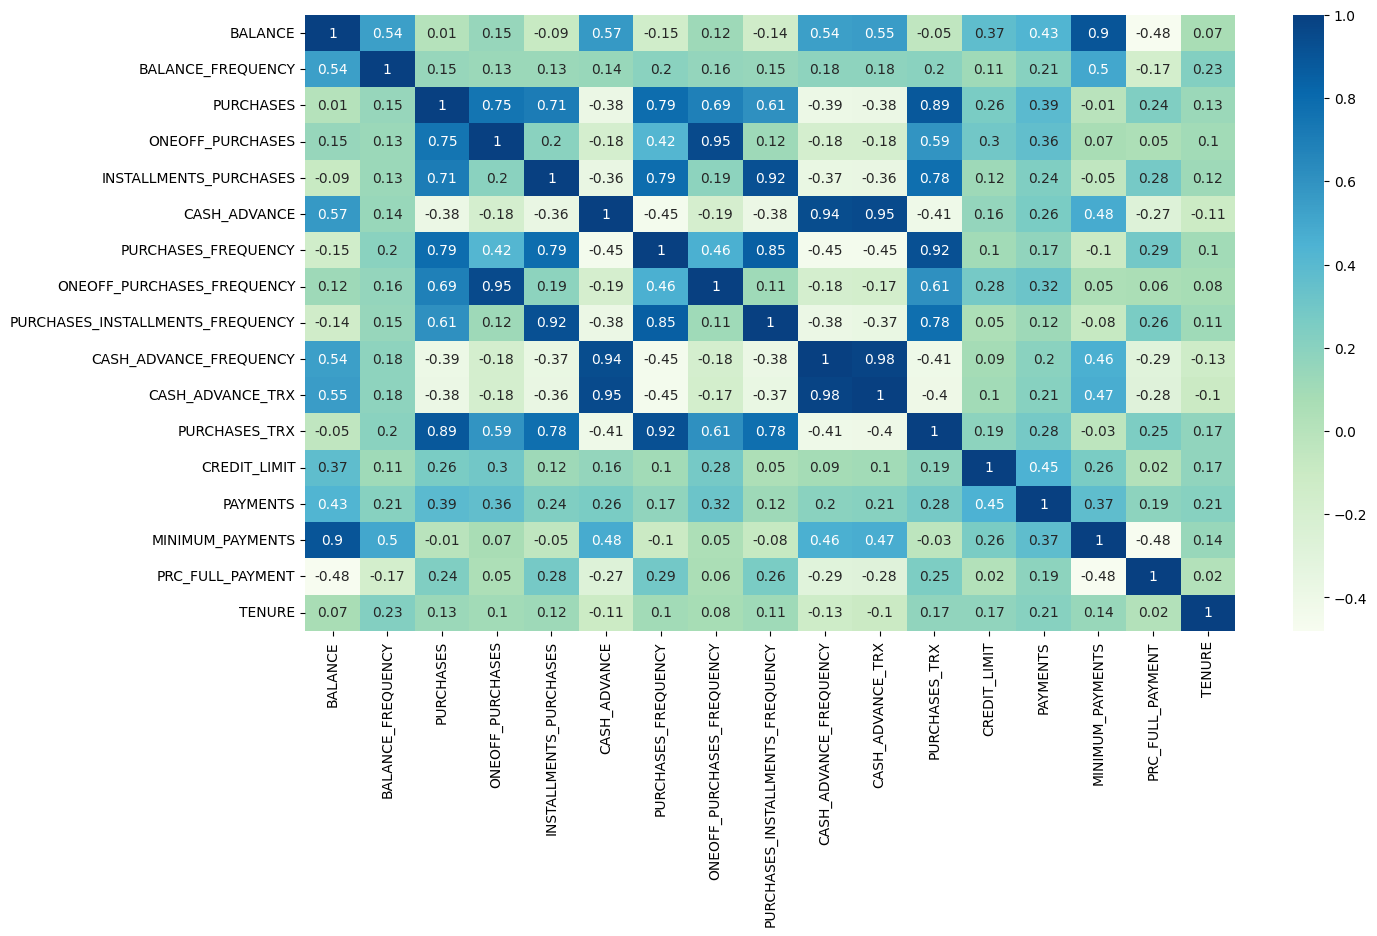

In [5]:
from os import pidfd_open
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import plotly.express as px
from sklearn.cluster import BisectingKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
pddf= df.toPandas()
numerical_features = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

plt.figure(figsize=(15, 8))
sns.heatmap(round(pddf[numerical_features].corr(method='spearman'), 2),
            annot=True, mask=None, cmap='GnBu')
plt.show()

Correlation features[1:12]  0.10432322392432858
<class 'pyspark.sql.dataframe.DataFrame'>


<Axes: >

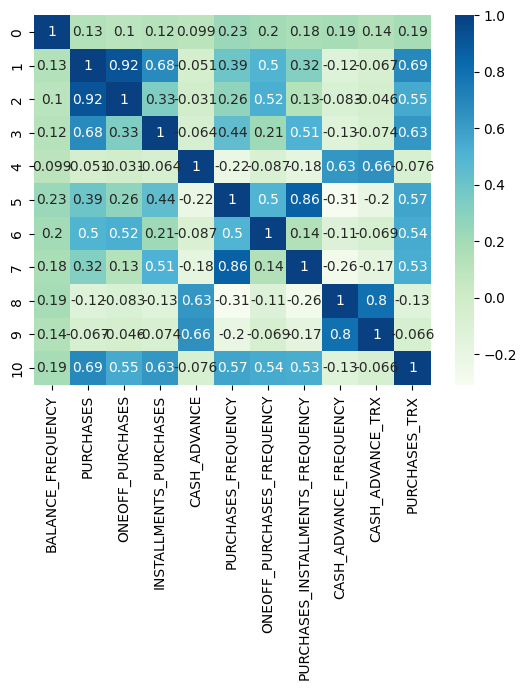

In [6]:
# Calculate Correlation Using Using MLlib
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
numerical_features = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

# Assemble feature vector
# Define the feature and label columns & Assemble the feature vector
vector_assembler = VectorAssembler(inputCols=numerical_features[1:12] , outputCol="features")
data_vector = vector_assembler.transform(df).select("features")

# Calculate correlation
correlation_matrix = Correlation.corr(data_vector, "features").head()[0]

print("Correlation features[1:12] ", correlation_matrix[0, 2])
df2 = spark.createDataFrame(correlation_matrix.toArray().tolist(),numerical_features[1:12])
print(type(df2))
sns.heatmap(df2.toPandas(),
            annot=True, mask=None, cmap='GnBu')

In [7]:
from pyspark.ml.feature import VectorAssembler
ClusteringColumns = ['BALANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY']

ClusteringColumns = [
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY']

assembler=VectorAssembler(inputCols=ClusteringColumns, outputCol="features")
featureDf = assembler.transform(df)
featureDf.printSchema()
featureDf.show(10)

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)
 |-- features: vector (nullable = true)

+-------+-----------+-----------------+---------+----------------+----------------------+----------

In [8]:
#preparing data for clustering
featureDf.count()
trainingData, testData = featureDf.randomSplit([0.7, 0.3], seed = 5043)
print(type(trainingData))
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
trainingData.show(10)
testData.columns

<class 'pyspark.sql.dataframe.DataFrame'>
Training Dataset Count: 6230
Test Dataset Count: 2720
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-------

['CUST_ID',
 'BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE',
 'features']

In [10]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
cluster_count = [5]#[10,30,50,70,90]
wssse_values =[]
for i in range(2,8):
  bkMeans = BisectingKMeans().setK(i).setSeed(1).setFeaturesCol("features").setPredictionCol("prediction")
  Model = bkMeans.fit(trainingData)

  # test the model with test data set
  predictDf = Model.transform(testData)


  evaluator = ClusteringEvaluator()
  silhouette = evaluator.evaluate(predictDf)

  wssse_values.append(silhouette)
  print("clusters= "+str(i) +" Silhouette with squared euclidean distance"+ str(silhouette))
  for clusters in Model.clusterCenters():
    print("cluster centres",clusters)

clusters= 2 Silhouette with squared euclidean distance0.7262330385019005
cluster centres [0.15687214 0.09449148 0.06073336]
cluster centres [0.88791336 0.33269989 0.72914872]
clusters= 3 Silhouette with squared euclidean distance0.5452105473860571
cluster centres [0.04737708 0.03477233 0.01107596]
cluster centres [0.39871251 0.22639241 0.17041105]
cluster centres [0.88791336 0.33269989 0.72914872]
clusters= 4 Silhouette with squared euclidean distance0.6517503864072903
cluster centres [0.04381032 0.03509053 0.00850546]
cluster centres [0.39306858 0.21858546 0.1698422 ]
cluster centres [0.86891019 0.09909662 0.81815044]
cluster centres [0.92690263 0.81198935 0.54654172]
clusters= 5 Silhouette with squared euclidean distance0.5556395420544814
cluster centres [0.         0.         0.00017593]
cluster centres [0.11479602 0.09194759 0.02200175]
cluster centres [0.39306858 0.21858546 0.1698422 ]
cluster centres [0.86891019 0.09909662 0.81815044]
cluster centres [0.92690263 0.81198935 0.5465

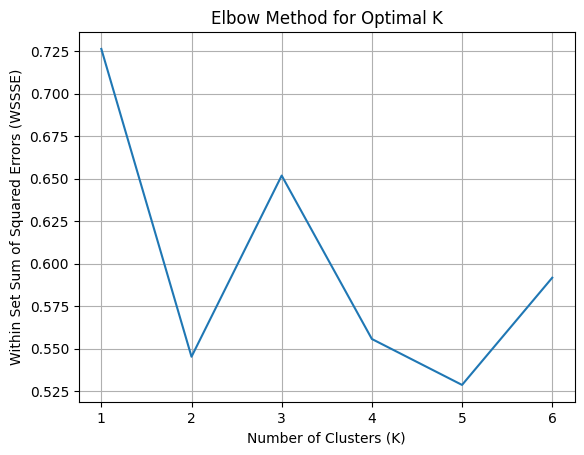

In [11]:
# Plotting WSSSE values
plt.plot(range(1, 7), wssse_values)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

In [12]:
# test the model with test data set
predictDf = Model.transform(testData)
predictDf.show(10)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictDf)
print("Silhouette with squared euclidean distance = " + str(silhouette))

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+----------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|prediction|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+-------

In [13]:
predictDf.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  373|
|         6|  411|
|         3|  252|
|         5|  545|
|         4|  289|
|         2|  228|
|         0|  622|
+----------+-----+



In [14]:
pddf_pred = predictDf.toPandas()

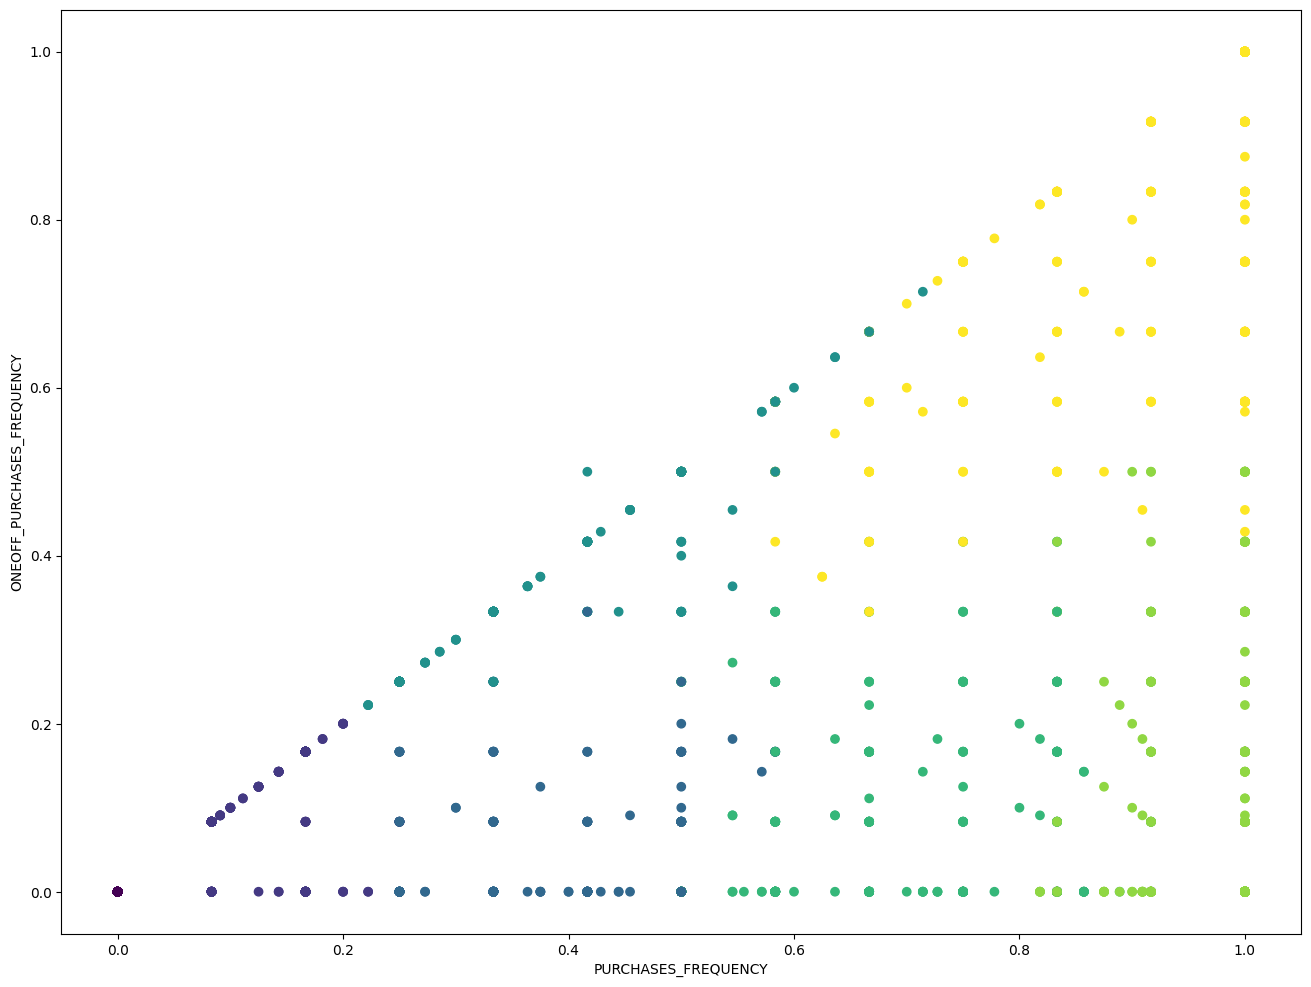

<Figure size 1200x1000 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
pddf_pred = predictDf.toPandas()
ClusteringColumns = ['BALANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY']
pddf_pred.head()
fig = plt.figure(figsize=(16,12))
KmVis= fig.add_subplot(111)
threedee = plt.figure(figsize=(12,10))
KmVis.scatter(pddf_pred.PURCHASES_FREQUENCY, pddf_pred.ONEOFF_PURCHASES_FREQUENCY,  c=pddf_pred.prediction)
KmVis.set_xlabel('PURCHASES_FREQUENCY')
KmVis.set_ylabel('ONEOFF_PURCHASES_FREQUENCY')

plt.show()

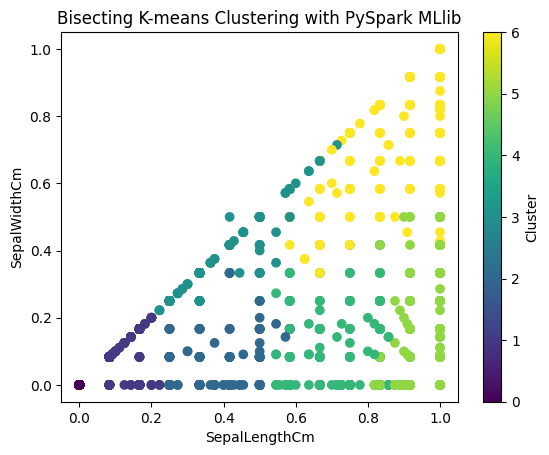

In [16]:
# Converting to Pandas DataFrame
clustered_data_pd = predictDf.toPandas()
# Visualizing the results
plt.scatter(clustered_data_pd["PURCHASES_FREQUENCY"], clustered_data_pd["ONEOFF_PURCHASES_FREQUENCY"], c=clustered_data_pd["prediction"], cmap='viridis')
plt.xlabel("SepalLengthCm")
plt.ylabel("SepalWidthCm")
plt.title("Bisecting K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

In [17]:
fig = px.scatter_3d(clustered_data_pd, x='PURCHASES_FREQUENCY', y='ONEOFF_PURCHASES_FREQUENCY', z='PURCHASES_INSTALLMENTS_FREQUENCY', color='prediction', symbol='BALANCE', template='ggplot2', hover_name='CASH_ADVANCE_FREQUENCY')
fig.show()

COMPARISION AND ANALYSIS BETWEEN K-MEANS AND BISECTING K-MEANS

1. CUSTOMER DATA SET
APPLYING K MEANS
clusters= 2 Silhouette with squared euclidean distance0.7262330385019005
clusters= 3 Silhouette with squared euclidean distance0.7618353464955893
clusters= 4 Silhouette with squared euclidean distance0.7508674978255471
clusters= 5 Silhouette with squared euclidean distance0.7556985880680238
clusters= 6 Silhouette with squared euclidean distance0.693947127898216
clusters= 7 Silhouette with squared euclidean distance0.7067429941796463

# test the model with test data set
Silhouette with squared euclidean distance = 0.7067429941796463

APPLYING BISECTING K MEANS
clusters= 2 Silhouette with squared euclidean distance0.7262330385019005
clusters= 3 Silhouette with squared euclidean distance0.5452105473860571
clusters= 4 Silhouette with squared euclidean distance0.6517503864072903
clusters= 5 Silhouette with squared euclidean distance0.5556395420544814
clusters= 6 Silhouette with squared euclidean distance0.5286239944712695
clusters= 7 Silhouette with squared euclidean distance0.5916706901165932

# test the model with test data set
Silhouette with squared euclidean distance = 0.5916706901165932

